In [1]:
import numpy as np
from osgeo import gdal, osr
from tqdm import tqdm, trange
import torch
import matplotlib.pyplot as plt

from esd_quantizer import Quantizer

In [2]:
tile_name = "36RUU"

dtset = gdal.Open(f"./SDC30_EBD_V001_{tile_name}_2024.tif")
ESD_codes = dtset.ReadAsArray()
dtset = None;    del dtset

_, H, W = ESD_codes.shape ## (12 temporal steps + 1 QA band, Height, Width)

ESD_codes.shape, ESD_codes.dtype

((13, 3600, 3600), dtype('uint16'))

# 1. Convert ESD codes to vectors

In [3]:
quantizer = Quantizer()
quantizer.load_state_dict(torch.load("ESD_quantizer.pth"))

ESD_vectors = np.empty([12, 6, H, W], dtype=np.float32)
for ir in trange(H):
    with torch.no_grad():
        quantized = quantizer.indices_to_codes(torch.from_numpy(ESD_codes[:12, ir, :].astype(np.int32)))
        quantized = quantized.permute([0,2,1])
        ESD_vectors[:, :, ir, :] = quantized[:, :, :].cpu().numpy()

ESD_vectors.shape  ## (months, channels, height, width)

100%|██████████████████████████████████████████████████████████████████████████████| 3600/3600 [00:03<00:00, 977.97it/s]


(12, 6, 3600, 3600)

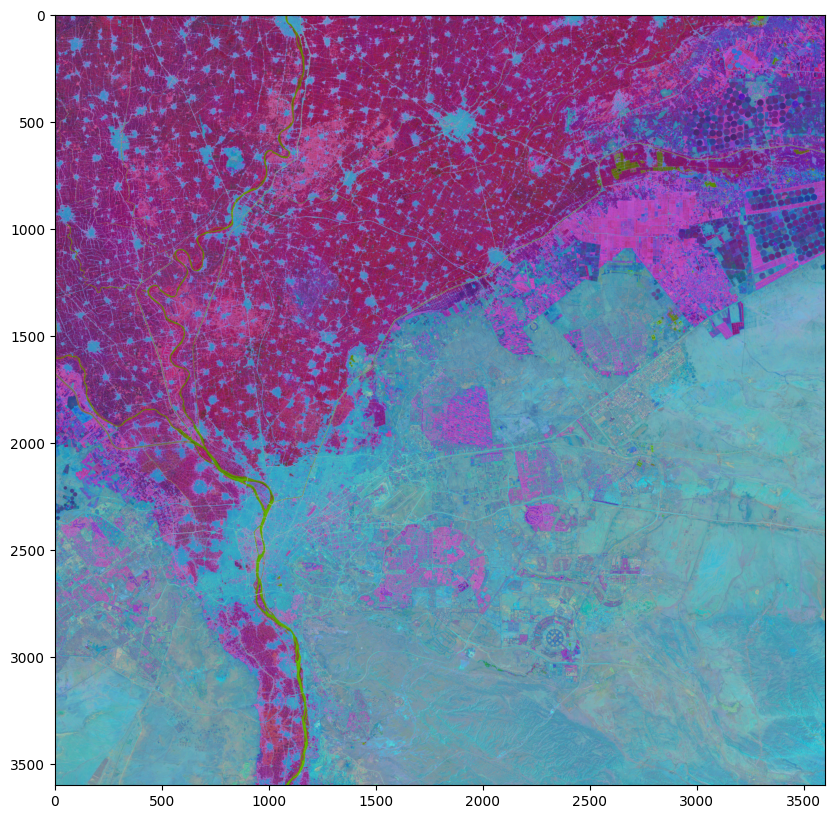

In [4]:
def ESD2IMG(codes, vectors):
    valid_mask = ~np.all(codes[:12] == 0, axis=0)
    # Convert to RGB image
    disp_img = np.zeros([3600, 3600, 4], dtype=np.uint8)  # RGBA
    disp_img[:, :, 0] = (np.mean(vectors[:, 5], axis=0) + 1) / 2 * 255
    disp_img[:, :, 1] = (np.mean(vectors[:, 1], axis=0) + 1) / 2 * 255
    disp_img[:, :, 2] = (np.mean(vectors[:, 2], axis=0) + 1) / 2 * 255
    # Mask areas without valid ESD data
    disp_img[:, :, 3] = np.where(valid_mask, 255, 0).astype(np.uint8)
    return disp_img


plt.figure(figsize=(10, 10))
plt.imshow(ESD2IMG(ESD_codes, ESD_vectors))

# 2. Load land cover data

In [5]:
dataset = gdal.Open(f"./FROMGLC30_V001_36RUU_2024.tif")
FROMGLC30 = dataset.ReadAsArray()[:H, :W]
del dataset

FROMGLC30.shape, FROMGLC30.dtype

((3600, 3600), dtype('uint8'))

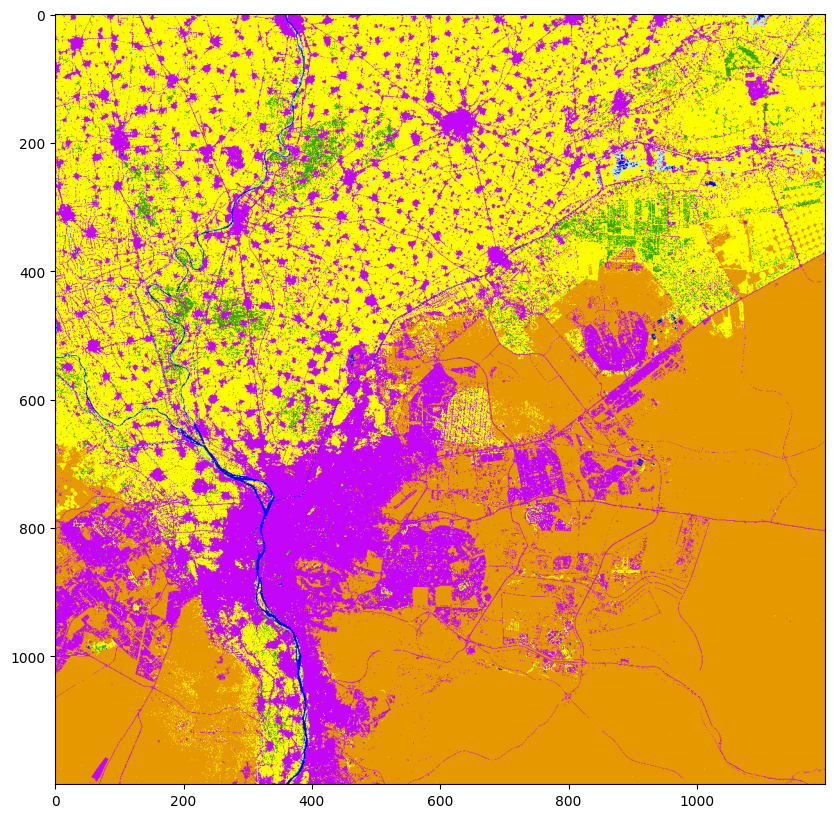

In [6]:
src_cmap = {
    0:  (  0,   0,   0,    0),
    10:  (253, 253,   0, 255),
    20:  ( 56, 167,   0, 255),
    30:  (163, 255, 118, 255),
    40:  (168, 168,   0, 255),
    50:  (190, 232, 255, 255),
    60:  (  0,   0, 255, 255),
    70:  (200, 215, 158, 255),
    80:  (195,   5, 250, 255),
    90:  (230, 152,   0, 255),
    100: (115, 255, 223, 255),
    255: (  0,   0,   0,   0),
}
def FG2img(data):
    H, W = data.shape
    image = np.zeros([H, W, 3], dtype=np.uint8)
    for ele in src_cmap:
        image[data == ele] = src_cmap[ele][:3]
    return image

plt.figure(figsize=(10,10))
plt.imshow(FG2img(FROMGLC30[::3, ::3]))

# 3. Randomly sample some locations for training

In [7]:
from sklearn.linear_model import RidgeClassifier

In [8]:
training_coords = []
training_labels = []

coords = np.where(FROMGLC30 != 255)
idx_list = np.random.choice(range(len(coords[0])), size=1000)
for idx in idx_list:
    ir, ic = coords[0][idx], coords[1][idx]
    training_coords.append(
        [ir, ic]
    )
    training_labels.append(FROMGLC30[ir, ic])
        
len(training_coords)

1000

(3600, 3600)

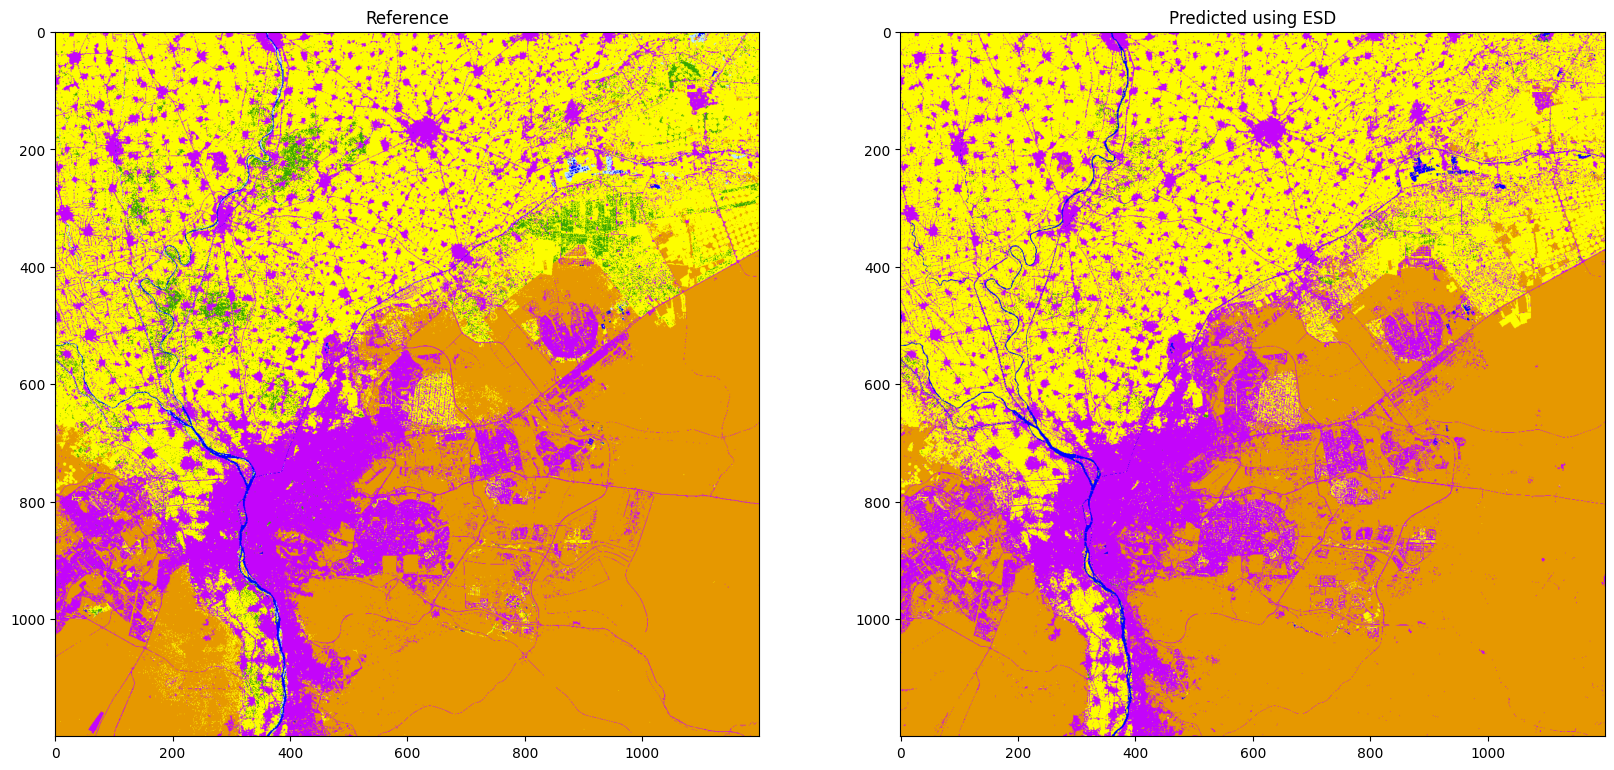

In [9]:
in_features = ESD_vectors.reshape([-1, H, W])

clf = RidgeClassifier().fit(
    X = in_features[:, [ele[0] for ele in training_coords], [ele[1] for ele in training_coords]].T,
    y = training_labels,
)

predicted = clf.predict(in_features.reshape([-1, H*W]).T).reshape([H, W])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
axes[0].imshow(FG2img(FROMGLC30[::3, ::3]))
axes[1].imshow(FG2img(predicted[::3, ::3]))

axes[0].set_title("Reference")
axes[1].set_title("Predicted using ESD")

predicted.shape